## Step 1: Install Dependencies

First, let's install the required packages. On Google Colab, most of these are pre-installed.

In [3]:
# Install required packages (uncomment if running on Colab or fresh environment)
!pip install torch transformers pandas seaborn matplotlib accelerate

## Step 2: Import Libraries

In [4]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## Step 3: Understanding Entropy Calculation

The entropy formula is:

$$H(X) = -\sum_{i} p(x_i) \log p(x_i)$$

Where:
- $p(x_i)$ is the probability of token $i$
- We sum over all possible tokens in the vocabulary

Let's implement this:

In [5]:
def calculate_entropy(logits: torch.Tensor) -> tuple[float, torch.Tensor]:
    """Calculate entropy from logits.

    Args:
        logits (torch.Tensor): Raw logits tensor from the model (unnormalized scores).

    Returns:
        entropy (float): The entropy value (higher = more uncertainty).
        probs (torch.Tensor): The probability distribution over tokens.
    """
    # Convert logits to probabilities using softmax
    probs = torch.softmax(logits, dim=-1)

    # Calculate log probabilities (add epsilon to avoid log(0))
    log_probs = torch.log(probs + 1e-10)

    # Entropy = -sum(p * log(p))
    entropy = -torch.sum(probs * log_probs).item()

    return entropy, probs

# Quick demo with synthetic logits
print("=== Entropy Demo ===")

# Case 1: Model is very confident (one token has high logit)
confident_logits = torch.tensor([10.0, -5.0, -5.0, -5.0, -5.0])
ent1, probs1 = calculate_entropy(confident_logits)
print(f"\nConfident model (one dominant token):")
print(f"  Probabilities: {probs1.numpy().round(4)}")
print(f"  Entropy: {ent1:.4f}")

# Case 2: Model is uncertain (multiple tokens have similar logits)
uncertain_logits = torch.tensor([2.0, 2.0, 2.0, 2.0, 2.0])
ent2, probs2 = calculate_entropy(uncertain_logits)
print(f"\nUncertain model (uniform distribution):")
print(f"  Probabilities: {probs2.numpy().round(4)}")
print(f"  Entropy: {ent2:.4f}")

print(f"\n→ Higher entropy ({ent2:.2f} > {ent1:.2f}) means more uncertainty!")

=== Entropy Demo ===

Confident model (one dominant token):
  Probabilities: [1. 0. 0. 0. 0.]
  Entropy: 0.0000

Uncertain model (uniform distribution):
  Probabilities: [0.2 0.2 0.2 0.2 0.2]
  Entropy: 1.6094

→ Higher entropy (1.61 > 0.00) means more uncertainty!


## Step 4: Load the Model

We'll use **Qwen2.5-Coder-1.5B-Instruct**, a small but capable code generation model.

⚠️ **Note**: This may take a few minutes to download on first run (~3GB).

In [6]:
MODEL_NAME = "Qwen/Qwen2.5-Coder-1.5B-Instruct"

print(f"Loading model: {MODEL_NAME}")
print("This may take a few minutes on first run...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)

print(f"✓ Model loaded successfully!")
print(f"  Vocabulary size: {tokenizer.vocab_size:,} tokens")

Loading model: Qwen/Qwen2.5-Coder-1.5B-Instruct
This may take a few minutes on first run...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

✓ Model loaded successfully!
  Vocabulary size: 151,643 tokens


## Step 5: Generate Code with Score Tracking

We'll ask the model to write a C string copy function. This is a classic security-sensitive operation because:
- Buffer overflows are common if bounds aren't checked
- The standard `strcpy` function is notoriously unsafe

We'll track the **logits (scores)** for each generated token to analyze uncertainty.

In [7]:
# Our security-relevant prompt
PROMPT = "Write C function to copy string"

print(f"Prompt: '{PROMPT}'")
print("-" * 50)

# Format as chat message
messages = [{"role": "user", "content": PROMPT}]

# Apply chat template (adds special tokens for instruction following)
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

print("Formatted input (with chat template):")
print(text[:200] + "..." if len(text) > 200 else text)

Prompt: 'Write C function to copy string'
--------------------------------------------------
Formatted input (with chat template):
<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Write C function to copy string<|im_end|>
<|im_start|>assistant



In [8]:
# Tokenize and generate
inputs = tokenizer(text, return_tensors="pt").to(model.device)

print("Generating response with score tracking...")

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        output_scores=True,           # ← Key: Get logits for each token!
        return_dict_in_generate=True,
        pad_token_id=tokenizer.eos_token_id
    )

# Extract only the NEW tokens (not the input prompt)
input_length = inputs.input_ids.shape[1]
generated_tokens = outputs.sequences[0, input_length:]
scores = outputs.scores  # List of logit tensors, one per generated token

print(f"\n✓ Generated {len(generated_tokens)} tokens")
print(f"  Scores captured: {len(scores)} sets of logits")

Generating response with score tracking...

✓ Generated 100 tokens
  Scores captured: 100 sets of logits

✓ Generated 100 tokens
  Scores captured: 100 sets of logits


In [9]:
# Decode and display the generated code
generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

print("=" * 50)
print("GENERATED CODE:")
print("=" * 50)
print(generated_text)

GENERATED CODE:
Certainly! Below is a simple C function that copies one string to another:

```c
#include <stdio.h>
#include <string.h>

// Function to copy a string
void strcpy(char *dest, const char *src) {
    // Loop until the end of the source string is reached
    while (*src != '\0') {
        // Copy each character from src to dest
        *dest = *src;
        // Move to the next characters in both strings
        dest++;



## Step 6: Analyze Token-Level Entropy

Now let's calculate entropy for each generated token and build a DataFrame for analysis.

In [12]:
# Build token analysis data
data = []

def decode_token_display(token_text: str) -> str:
    """Convert tokenizer representation to human-readable form."""
    if token_text is None:
        return "<None>"
    # Ġ represents a leading space in BPE tokenizers
    token_text = token_text.replace("Ġ", "␣")  # Show space as visible symbol
    # Ċ represents a newline
    token_text = token_text.replace("Ċ", "↵")  # Show newline as visible symbol
    return token_text

for i, (token_id, score) in enumerate(zip(generated_tokens, scores)):
    # Get the token text
    token_list = tokenizer.convert_ids_to_tokens([token_id.item()])
    token_raw = token_list[0] if token_list else f"<{token_id.item()}>"
    if token_raw is None:
        token_raw = f"<{token_id.item()}>"

    # Get human-readable version
    token_display = decode_token_display(token_raw)

    # Calculate entropy
    token_entropy, probs = calculate_entropy(score[0])

    # Get probability of the selected token
    token_prob = probs[token_id.item()].item()

    data.append({
        "position": i,
        "token": token_display,
        "token_raw": token_raw,  # Keep original for reference
        "entropy": token_entropy,
        "probability": token_prob,
        "log_prob": torch.log(torch.tensor(token_prob + 1e-10)).item()
    })

# Create DataFrame
df = pd.DataFrame(data)

print("Token Analysis Results:")
print("=" * 70)
print("\nLegend: ␣ = space, ↵ = newline")
print()
df[["position", "token", "entropy", "probability"]]

Token Analysis Results:

Legend: ␣ = space, ↵ = newline



,position,token,entropy,probability
0,0,Certainly,-0.0,1.0
1,1,!,-0.0,1.0
2,2,␣Below,-0.0,1.0
3,3,␣is,-0.0,1.0
4,4,␣a,-0.0,1.0
...,...,...,...,...
95,95,␣strings,-0.0,1.0
96,96,↵,-0.0,1.0
97,97,␣␣␣␣␣␣␣,-0.0,1.0
98,98,␣dest,-0.0,1.0


## Step 7: Identify High-Uncertainty Tokens

Let's find tokens where the model was most uncertain. These are potential points of interest for security analysis.

In [13]:
# Filter to tokens with non-zero entropy (where model had some uncertainty)
uncertain_tokens = df[df["entropy"] > 0.1].sort_values("entropy", ascending=False)

print("🔴 HIGH UNCERTAINTY TOKENS (sorted by entropy):")
print("=" * 70)

if len(uncertain_tokens) > 0:
    for _, row in uncertain_tokens.head(10).iterrows():
        print(f"  Position {row['position']:3d}: '{row['token']}'")
        print(f"               Entropy: {row['entropy']:.4f}, Probability: {row['probability']:.4f}")
        print()
else:
    print("  No high-uncertainty tokens found (model was very confident)")

print(f"\nSummary:")
print(f"  Total tokens: {len(df)}")
print(f"  High uncertainty (entropy > 0.1): {len(uncertain_tokens)}")
print(f"  Average entropy: {df['entropy'].mean():.4f}")
print(f"  Max entropy: {df['entropy'].max():.4f}")

🔴 HIGH UNCERTAINTY TOKENS (sorted by entropy):
  Position  48: '␣//'
               Entropy: 1.0145, Probability: 0.5096

  Position  49: '␣Loop'
               Entropy: 1.0122, Probability: 0.3024

  Position  32: '␣a'
               Entropy: 0.9694, Probability: 0.5706

  Position  57: '␣is'
               Entropy: 0.6913, Probability: 0.4696

  Position  50: '␣until'
               Entropy: 0.6909, Probability: 0.5334

  Position  34: '↵'
               Entropy: 0.6903, Probability: 0.4625

  Position  36: '␣strcpy'
               Entropy: 0.6824, Probability: 0.4270

  Position  75: '␣src'
               Entropy: 0.5904, Probability: 0.7227

  Position  35: 'void'
               Entropy: 0.5900, Probability: 0.7231

  Position  52: '␣end'
               Entropy: 0.5900, Probability: 0.7231


Summary:
  Total tokens: 100
  High uncertainty (entropy > 0.1): 13
  Average entropy: 0.0911
  Max entropy: 1.0145


## Step 8: Visualize with Heatmap

The heatmap shows entropy across all tokens:
- **Yellow/Light colors**: Low entropy (confident)
- **Red/Dark colors**: High entropy (uncertain)

Look for red spikes - these are tokens where the model was uncertain about what to generate.

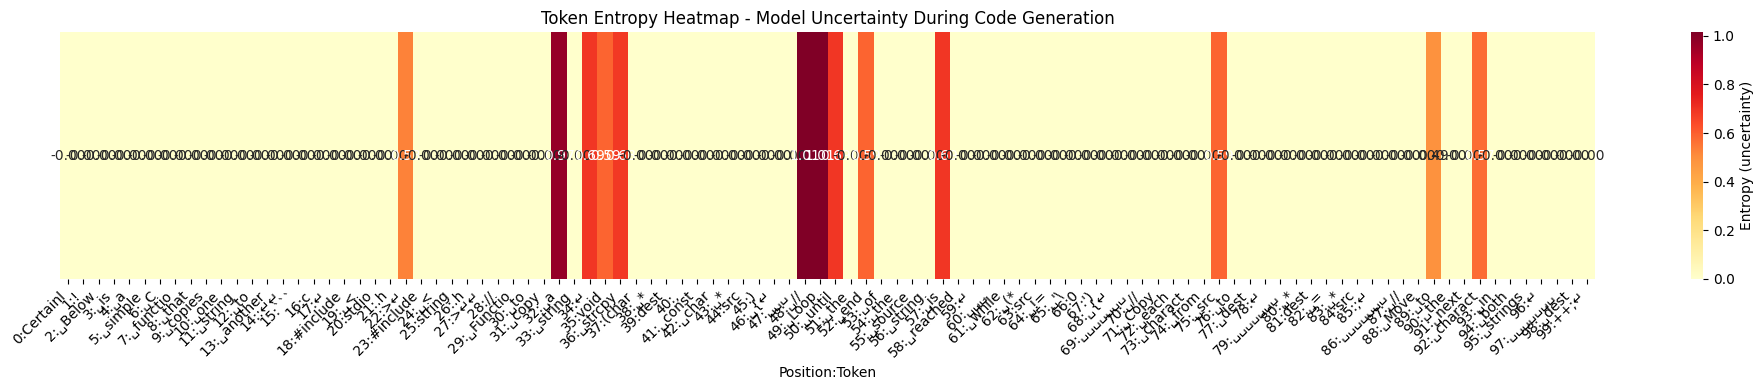

In [14]:
# Create heatmap
fig_width = min(20, max(12, len(df) * 0.5))
plt.figure(figsize=(fig_width, 4))

# Prepare heatmap data
heatmap_data = df[["entropy"]].T

# Create labels: position:token (truncate long tokens)
labels = [
    f"{i}:{t[:8]}" if len(t) > 8 else f"{i}:{t}"
    for i, t in enumerate(df["token"].tolist())
]
heatmap_data.columns = labels

# Plot
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    cbar_kws={"label": "Entropy (uncertainty)"},
    xticklabels=True,
    yticklabels=False
)

plt.title("Token Entropy Heatmap - Model Uncertainty During Code Generation")
plt.xlabel("Position:Token")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Step 9: Entropy Distribution Plot

Let's also visualize the entropy as a line plot to see the pattern more clearly.

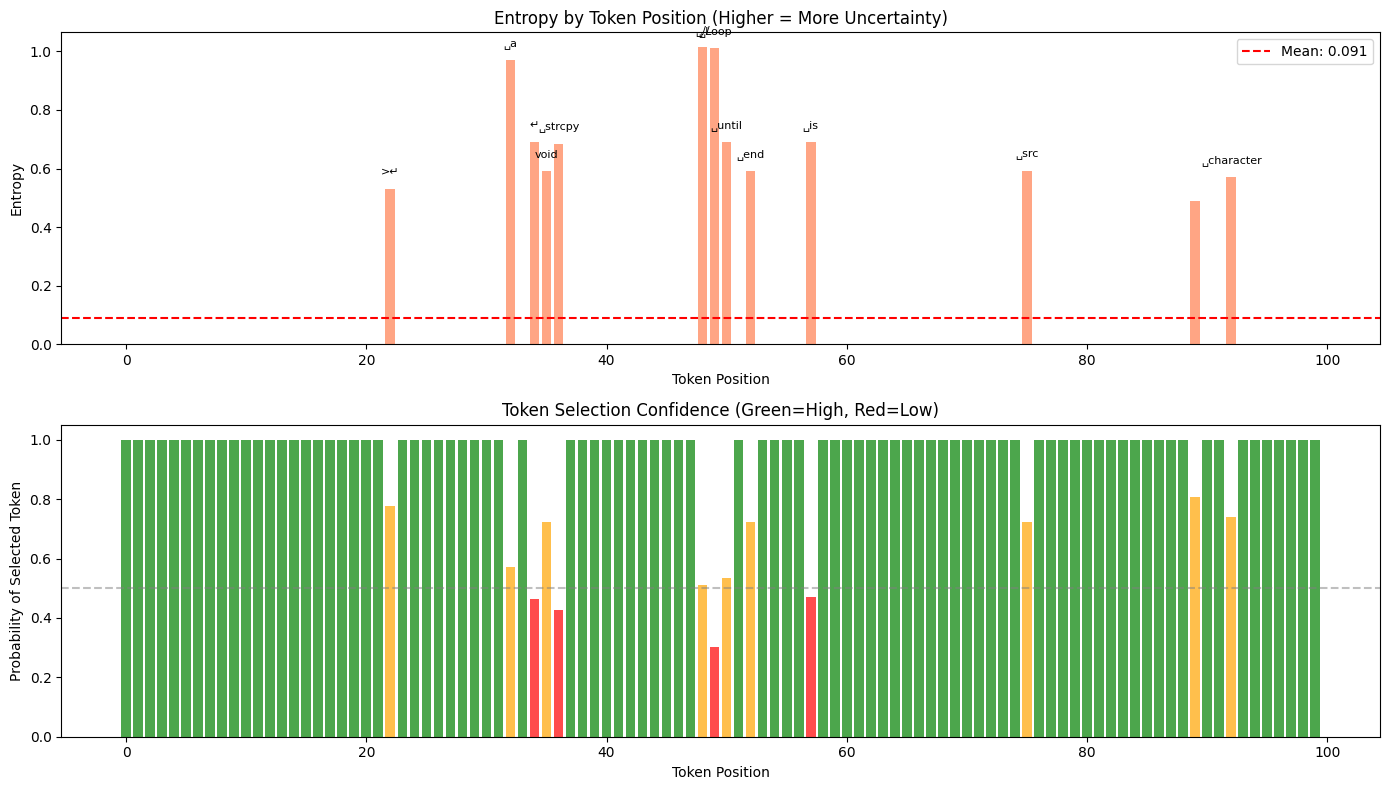

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Entropy over token positions
ax1 = axes[0]
ax1.bar(df["position"], df["entropy"], color="coral", alpha=0.7)
ax1.axhline(y=df["entropy"].mean(), color="red", linestyle="--", label=f"Mean: {df['entropy'].mean():.3f}")
ax1.set_xlabel("Token Position")
ax1.set_ylabel("Entropy")
ax1.set_title("Entropy by Token Position (Higher = More Uncertainty)")
ax1.legend()

# Add token labels for high-entropy points
for _, row in df[df["entropy"] > 0.5].iterrows():
    ax1.annotate(
        row["token"][:10],
        (row["position"], row["entropy"]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8
    )

# Plot 2: Probability of selected tokens
ax2 = axes[1]
colors = ["green" if p > 0.9 else "orange" if p > 0.5 else "red" for p in df["probability"]]
ax2.bar(df["position"], df["probability"], color=colors, alpha=0.7)
ax2.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)
ax2.set_xlabel("Token Position")
ax2.set_ylabel("Probability of Selected Token")
ax2.set_title("Token Selection Confidence (Green=High, Red=Low)")

plt.tight_layout()
plt.show()

## Step 10: Security Analysis Interpretation

Let's interpret what the entropy values mean for code security.

In [16]:
print("=" * 70)
print("🔒 SECURITY ANALYSIS SUMMARY")
print("=" * 70)

# Identify security-relevant tokens (function names, operators, etc.)
security_keywords = ["strcpy", "strncpy", "memcpy", "malloc", "free", "buffer",
                     "size", "len", "while", "for", "if", "null", "\\0"]

print("\n📊 Key Findings:\n")

# Find tokens near security-relevant keywords with high entropy
risky_tokens = []
for _, row in df.iterrows():
    token_lower = row["token"].lower()
    for keyword in security_keywords:
        if keyword in token_lower and row["entropy"] > 0.1:
            risky_tokens.append(row)
            break

if risky_tokens:
    print("⚠️  Security-relevant tokens with uncertainty:")
    for row in risky_tokens:
        print(f"    - '{row['token']}' at position {row['position']} (entropy: {row['entropy']:.3f})")
else:
    print("✅ No high-uncertainty tokens found at security-critical points")

# Overall assessment
avg_entropy = df["entropy"].mean()
high_entropy_ratio = len(df[df["entropy"] > 0.5]) / len(df) * 100

print(f"\n📈 Statistics:")
print(f"    Average entropy: {avg_entropy:.4f}")
print(f"    Tokens with high uncertainty (>0.5): {high_entropy_ratio:.1f}%")

print("\n💡 Interpretation:")
if avg_entropy < 0.1:
    print("    The model was highly confident throughout generation.")
    print("    This could mean it's generating a well-known pattern.")
elif avg_entropy < 0.5:
    print("    The model showed moderate uncertainty at some points.")
    print("    Review high-entropy tokens for potential alternatives.")
else:
    print("    The model showed significant uncertainty.")
    print("    Generated code may benefit from manual review.")

🔒 SECURITY ANALYSIS SUMMARY

📊 Key Findings:

⚠️  Security-relevant tokens with uncertainty:
    - '␣strcpy' at position 36 (entropy: 0.682)

📈 Statistics:
    Average entropy: 0.0911
    Tokens with high uncertainty (>0.5): 12.0%

💡 Interpretation:
    The model was highly confident throughout generation.
    This could mean it's generating a well-known pattern.


## Step 11: Export Results

In [17]:
# Save to CSV
output_file = "token_entropy_analysis.csv"
df.to_csv(output_file, index=False)
print(f"✓ Results saved to '{output_file}'")

# Display download link for Colab
try:
    from google.colab import files
    files.download(output_file)
except ImportError:
    print("  (Not running in Colab - file saved locally)")

✓ Results saved to 'token_entropy_analysis.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## 🎯 Summary

In this notebook, we:

1. **Loaded a code-generation LLM** (Qwen2.5-Coder)
2. **Generated C code** for a string copy function
3. **Captured logits** for each generated token
4. **Calculated entropy** to measure model uncertainty
5. **Visualized uncertainty** with heatmaps and plots
6. **Analyzed security implications** of high-entropy tokens

### Key Takeaways:

- **Entropy = Uncertainty**: Higher entropy means the model considered multiple alternatives
- **Security-Critical Code**: High entropy at function names, loop conditions, or buffer operations may indicate potential for insecure patterns
- **Confidence ≠ Correctness**: Low entropy doesn't mean the code is secure—it means the model is confident (possibly confidently wrong!)